In [ ]:
import polars as pl
import seaborn as sns

from rs_graph.db import constants as db_constants

###############################################################################


def _read_table(table: str) -> pl.DataFrame:
    return pl.read_database_uri(
        f"SELECT * FROM {table}",
        f"sqlite:///{db_constants.V2_DATABASE_PATHS.dev}",
    )


def load_pairs() -> pl.DataFrame:
    # Read all the tables we need
    docs = _read_table("document")
    repos = _read_table("repository")
    pairs = _read_table("document_repository_link")

    repo_contribs = _read_table("repository_contributor")

    # Drop to unique doc and unique repo in pairs
    pairs = pairs.unique(
        subset="document_id",
        keep="none",
    ).unique(
        subset="repository_id",
        keep="none",
    )

    # Join the tables to get the positive examples
    df = (
        pairs.select(
            "document_id",
            "repository_id",
        )
        .join(
            docs.select(
                pl.col("id").alias("document_id"),
                "publication_date",
            ),
            on="document_id",
            how="left",
        )
        .join(
            repos.select(
                pl.col("id").alias("repository_id"),
                "creation_datetime",
                "last_pushed_datetime",
            ),
            on="repository_id",
            how="left",
        )
    )

    return df, repo_contribs


df, repo_contribs = load_pairs()
df

document_id,repository_id,publication_date,creation_datetime,last_pushed_datetime
i64,i64,date,datetime[ns],datetime[ns]
1,1,2015-12-01,2014-05-05 21:14:57,2018-04-29 16:11:15
2,2,2022-10-01,2021-11-09 04:35:52,2021-11-23 04:14:31
3,3,2017-12-08,2017-07-10 14:22:18,2018-07-11 12:15:35
4,4,2020-05-18,2019-04-01 16:16:34,2021-07-12 10:28:10
5,5,2017-09-29,2016-12-13 22:27:50,2024-03-25 19:35:00
…,…,…,…,…
138590,132078,2021-01-01,2021-02-06 13:04:58,2022-07-20 11:14:06
138591,132080,2021-01-01,2021-04-27 09:05:06,2022-01-05 21:05:54
138592,132081,2020-01-01,2020-05-25 19:59:39,2022-06-13 17:34:41


In [2]:
repo_contribs.group_by("repository_id").agg(pl.len().alias("num_contributors"))[
    "num_contributors"
].describe()

statistic,value
str,f64
"""count""",128992.0
"""null_count""",0.0
"""mean""",2.28139
"""std""",3.92659
"""min""",1.0
"""25%""",1.0
"""50%""",1.0
"""75%""",2.0
"""max""",32.0


In [3]:
# Create columns for difference between publication date and creation date
# and publication date and last pushed date
df = df.with_columns(
    (pl.col("publication_date") - pl.col("creation_datetime"))
    .dt.total_days()
    .alias("publication_date_creation_date_diff"),
    (pl.col("publication_date") - pl.col("last_pushed_datetime"))
    .dt.total_days()
    .alias("publication_date_last_pushed_date_diff"),
)

# Also create a "years" column for both of these
df = df.with_columns(
    (pl.col("publication_date_creation_date_diff") / 365.25).alias(
        "publication_date_creation_date_diff_years"
    ),
    (pl.col("publication_date_last_pushed_date_diff") / 365.25).alias(
        "publication_date_last_pushed_date_diff_years"
    ),
)

df["publication_date_creation_date_diff"].describe(
    percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99],
).filter(
    pl.col("statistic").is_in(["1%", "5%", "10%", "25%", "50%", "75%", "90%", "95%", "99%"])
)

statistic,value
str,f64
"""1%""",-763.0
"""5%""",-427.0
"""10%""",-326.0
"""25%""",-207.0
"""50%""",-35.0
"""75%""",86.0
"""90%""",374.0
"""95%""",685.0
"""99%""",1725.0


In [4]:
# Same for years
df["publication_date_creation_date_diff_years"].describe(
    percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99],
).filter(
    pl.col("statistic").is_in(["1%", "5%", "10%", "25%", "50%", "75%", "90%", "95%", "99%"])
)

statistic,value
str,f64
"""1%""",-2.08898
"""5%""",-1.169062
"""10%""",-0.892539
"""25%""",-0.566735
"""50%""",-0.095825
"""75%""",0.235455
"""90%""",1.023956
"""95%""",1.875428
"""99%""",4.722793


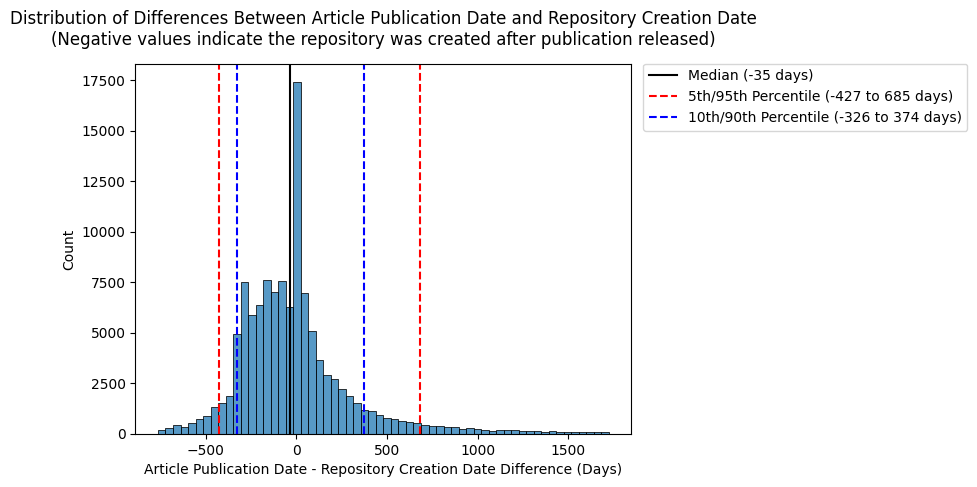

In [ ]:
# Remove outliers for visualization
viz_df = df.filter(
    pl.col("publication_date_creation_date_diff") <= 1724,
    pl.col("publication_date_creation_date_diff") >= -762,
)

ax = sns.histplot(
    data=viz_df.to_pandas(),
    x="publication_date_creation_date_diff",
    bins=60,
)
median = int(df["publication_date_creation_date_diff"].median())

# Percentiles
percentile_10_lower = int(df["publication_date_creation_date_diff"].quantile(0.10))
percentile_90_upper = int(df["publication_date_creation_date_diff"].quantile(0.90))
percentile_5_lower = int(df["publication_date_creation_date_diff"].quantile(0.05))
percentile_95_upper = int(df["publication_date_creation_date_diff"].quantile(0.95))

# Add line for median
ax.axvline(
    x=median,
    color="black",
    linestyle="solid",
    label=f"Median ({median} days)",
)
# Add lines for percentiles
ax.axvline(
    x=percentile_5_lower,
    color="red",
    linestyle="--",
    label=f"5th/95th Percentile ({percentile_5_lower} to {percentile_95_upper} days)",
)
ax.axvline(
    x=percentile_95_upper,
    color="red",
    linestyle="--",
)
ax.axvline(
    x=percentile_10_lower,
    color="blue",
    linestyle="--",
    label=f"10th/90th Percentile ({percentile_10_lower} to {percentile_90_upper} days)",
)
ax.axvline(
    x=percentile_90_upper,
    color="blue",
    linestyle="--",
)

# Add legend for the lines outside of plot area
ax.legend(bbox_to_anchor=(1.01, 1.02), loc="upper left")

# Set x axis label
ax.set_xlabel("Article Publication Date - Repository Creation Date Difference (Days)")

# Provide fig description (negative values mean repo created after publication date)
_ = ax.set_title(
    (
        "Distribution of Differences Between Article Publication Date and Repository Creation Date\n"
        "(Negative values indicate the repository was created after publication released)"
    ),
    pad=14,
)